In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from dataset import ImageDataset

# Cycle GAN
![Cycle-GAN](https://miro.medium.com/max/1838/0*S5gn5i6UhfyoRr9S.png)

# Step 1. Load Model

In [2]:
model_dir = './data/20210818/pth/epoch-300'
G_AB = torch.load(os.path.join(model_dir, 'G_AB.pth'))
G_BA = torch.load(os.path.join(model_dir, 'G_BA.pth'))

# Step 2. Load Data

In [3]:
transforms_ = transforms.Compose([
   # transforms.Resize(int(256*1.12), Image.BICUBIC),
    #transforms.RandomCrop(256, 256),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_dir = '/home/cgl/data/monet'
batch_size = 10
testloader = DataLoader(
    ImageDataset(data_dir, mode='test', transforms=transforms_),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 10
)

# Step 3. Sample images

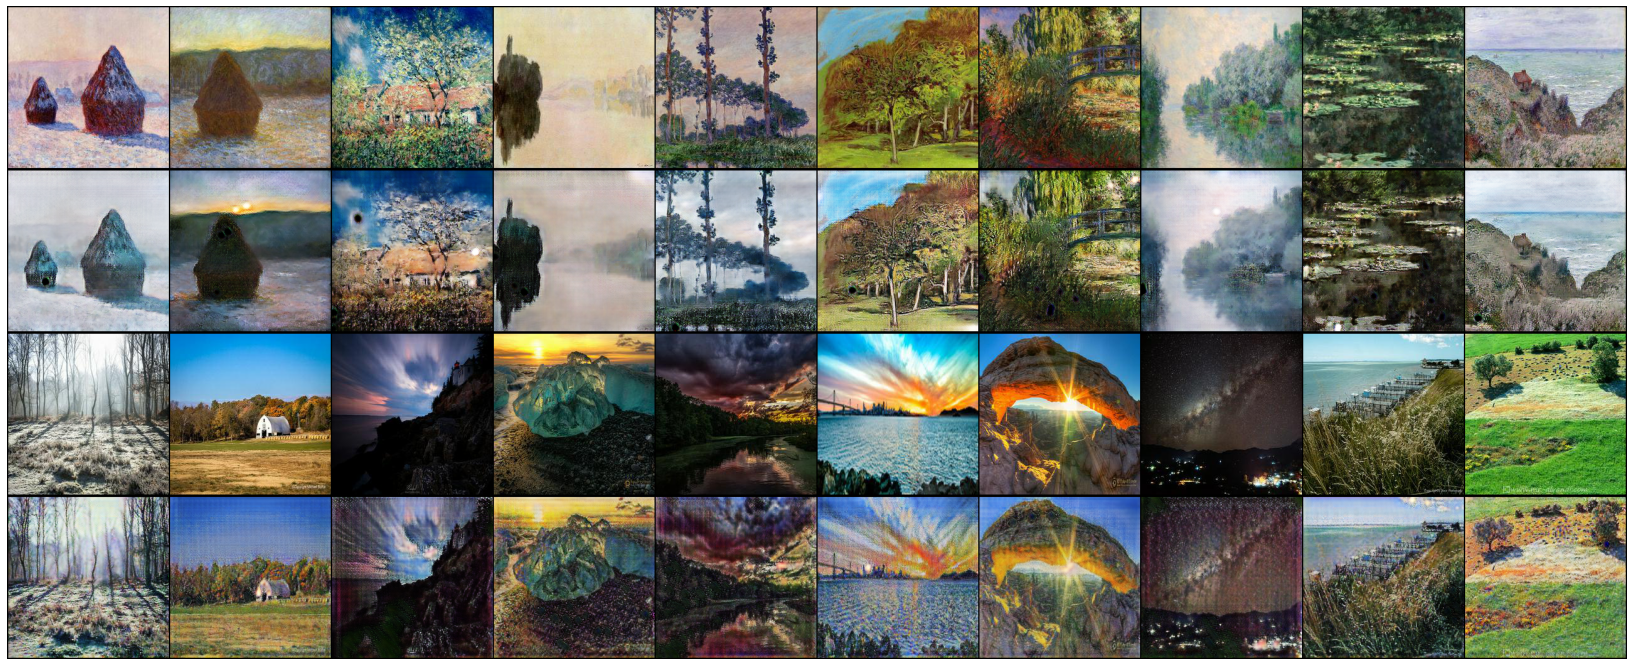

In [4]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

real_A, real_B = next(iter(testloader))
real_A = real_A.type(Tensor)
fake_B = G_AB(real_A).detach()
real_B = real_B.type(Tensor)
fake_A = G_BA(real_B).detach()

nrows = real_A.size(0)
grid_real_A = make_grid(real_A, nrow=nrows, normalize=True)
grid_fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
grid_real_B = make_grid(real_B, nrow=nrows, normalize=True)
grid_fake_A = make_grid(fake_A, nrow=nrows, normalize=True)

image_grid = torch.cat((grid_real_A, grid_fake_B, grid_real_B, grid_fake_A), 1).cpu().permute(1, 2, 0)

figside = 3
plt.figure(figsize=(figside*nrows, figside*4))
plt.imshow(image_grid)
plt.axis('off')
plt.show()

# Step 4. Generate

In [5]:
photo_dir = os.path.join(data_dir, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
len(files)

7038

In [9]:
generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = transforms.ToPILImage()

G_BA.eval()
imgs = []
fake_imgs = []
num_cols = 3
num_rows = 10
num_pictures = num_rows*num_cols

# random select pictures
pic_ids = np.random.choice(len(files), num_pictures, replace=False)
for i in pic_ids:
    img = Image.open(files[i])
    img = generate_transforms(img).type(Tensor).unsqueeze(0)
    imgs.append(img.cpu())
    
    fake_img = G_BA(img).detach().cpu()
    fake_imgs.append(fake_img)
imgs = torch.cat(imgs, 0) # n*3*256*256
fake_imgs = torch.cat(fake_imgs, 0) # n*3*256*256

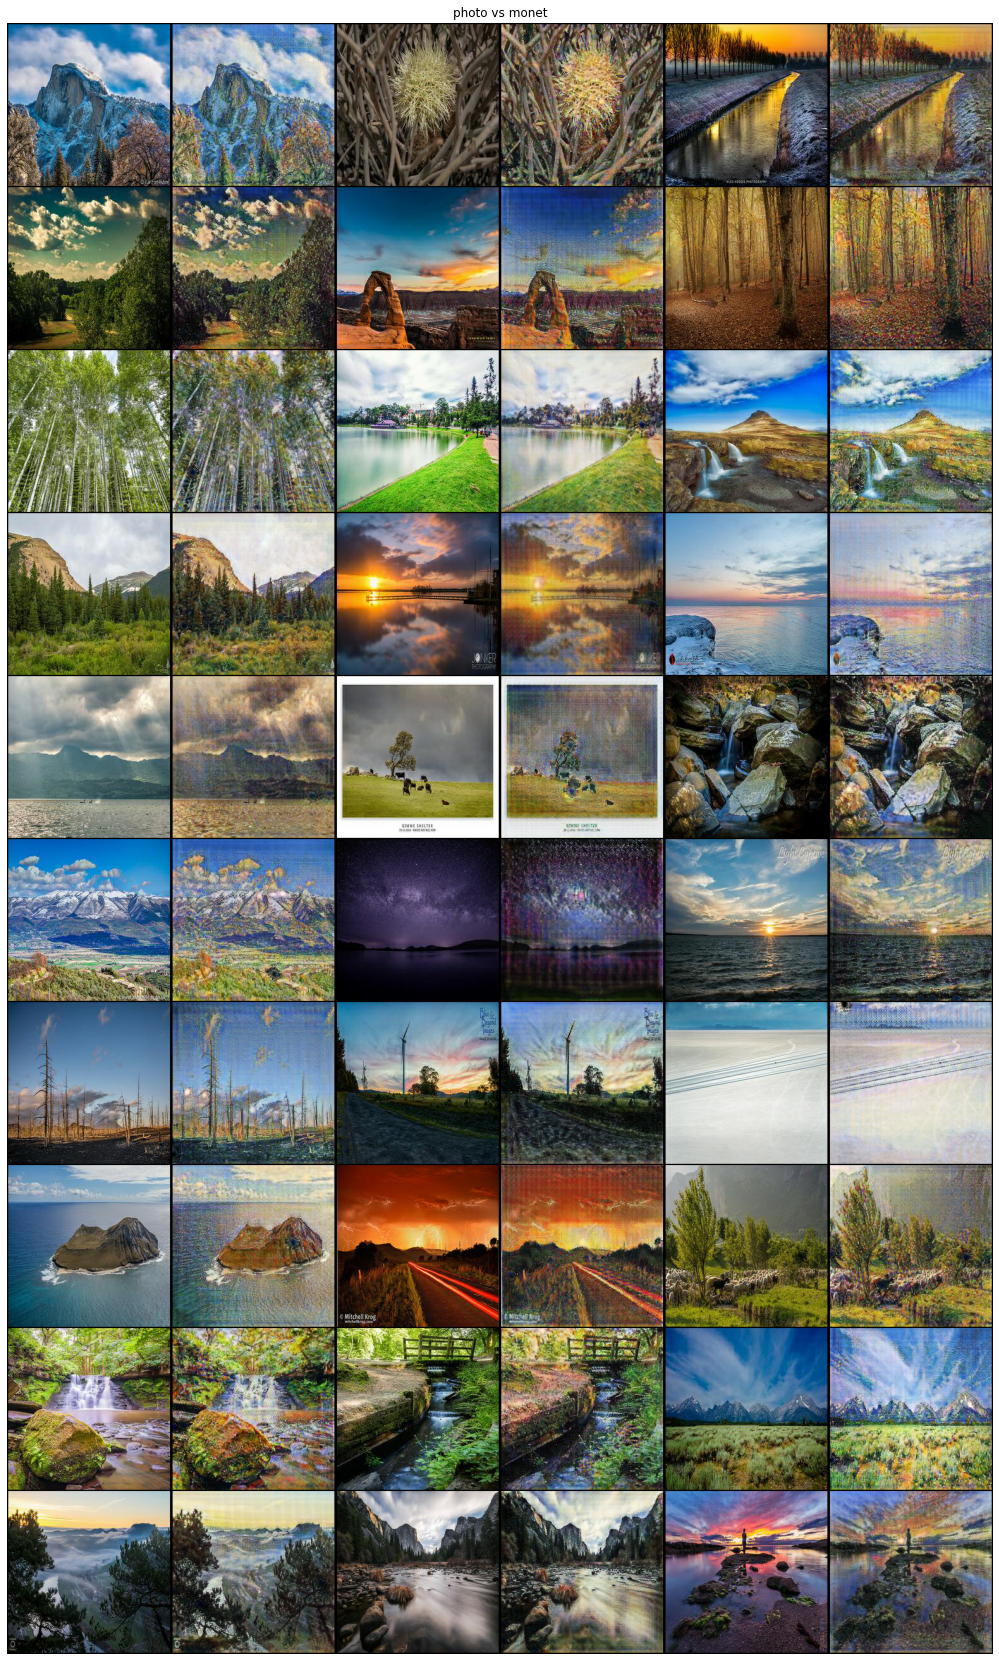

In [10]:
grids = []
for i in range(num_cols):
    grid_imgs = make_grid(imgs[i*num_rows:(i+1)*num_rows], nrow=1, normalize=True)
    grid_fake_imgs = make_grid(fake_imgs[i*num_rows:(i+1)*num_rows], nrow=1, normalize=True)
    grid = torch.cat((grid_imgs, grid_fake_imgs), 2).permute(1, 2, 0) # w*h*3  w=256*rows h=256*cols
    grids.append(grid)

grid_images = torch.cat(grids, 1)
figside = 3
plt.figure(figsize=(figside*num_cols*2, figside*num_rows))
plt.imshow(grid_images)
plt.axis('off')
plt.title('photo vs monet')
plt.show()